<a href="https://colab.research.google.com/github/Kushwho/SpeechEmoRecognition-Vanii/blob/main/SpeechEmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade adapt scikeras resampy==0.4.2 scikit-learn==1.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 22.6 MB/s eta 0:00:00
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=e41eabffefaa7169b2fe321aef691e844ceba6bb20a819093ea35b2e073a4258
  Stored in directory: /root/.cache/pip/wheels/cb/88/91/f7ac7b6024ad8778b5ecca6ebe44421105722648f2a6b7afd7
Successfully built adapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

In [ ]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import soundfile as sf
from IPython.display import Audio
import resampy
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import tree
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy import stats
import warnings
np.warnings = warnings
from tensorflow.keras.regularizers import l2

In [ ]:
!wget -O ravdess.zip https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
!unzip ravdess.zip -d ravdess_data

--2024-07-28 14:23:30--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2024-07-28 14:23:31--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘ravdess.zip’

ravdess.zip         100%[===================>] 198.81M  11.5MB/s    in 18s     

2024-07-28 14:23:49 (11.2 MB/s) - ‘ravdess.zip’ saved [208468073/208468073]

Archive:  ravdess.zip
   creating: ravdess_data/Actor_01/
  inflating: ravdess_data/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess_data/Actor_01/03-01-01-01-01-02-01.wav

In [ ]:
x, sr = librosa.load('/content/ravdess_data/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
sf.write('/content/MaleNeutral.wav', x, sr)

In [ ]:
Audio(data=x, rate=sr)

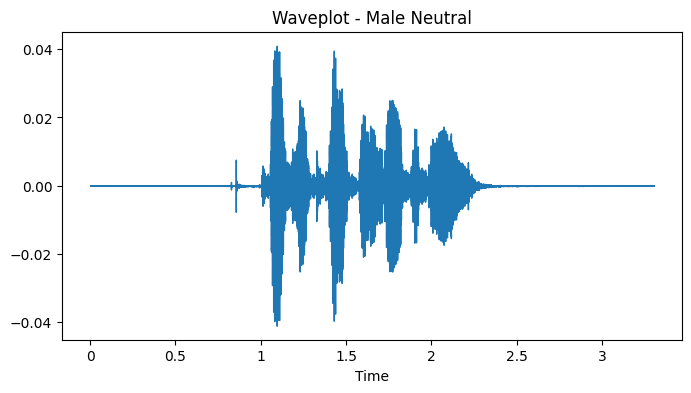

In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Neutral')
plt.savefig('Waveplot_MaleNeutral.png')

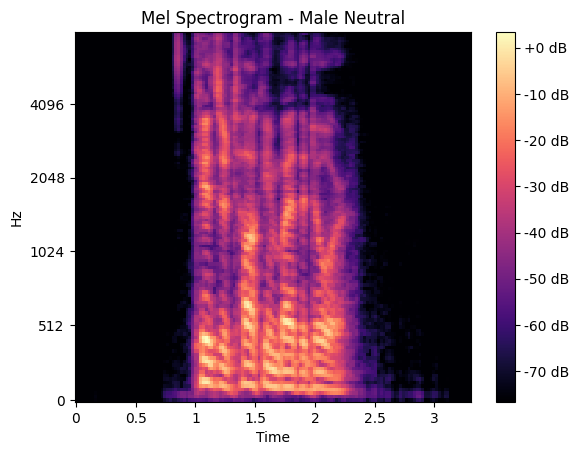

In [ ]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');

In [ ]:
def augment_audio(audio_data, sr):
    augmented = []
    # Time stretching
    stretch_rates = [0.9, 1.1]
    for rate in stretch_rates:
        augmented.append(librosa.effects.time_stretch(audio_data, rate=rate))

    # Pitch shifting
    pitch_shifts = [-2, 2]
    for n_steps in pitch_shifts:
        augmented.append(librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=n_steps))

    # Adding white noise
    noise_factor = 0.005
    noise = np.random.randn(len(audio_data))
    augmented.append(audio_data + noise_factor * noise)

    return augmented

In [ ]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
audio = '/content/ravdess_data/'
actor_folders = os.listdir(audio)
for i in actor_folders:
    filename = os.listdir(audio + i)
    for f in filename:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

        # Load audio file
        audio_data, sr = librosa.load(audio + i + '/' + f)

        # Generate augmented versions
        augmented_audio = augment_audio(audio_data, sr)

        # Save augmented versions and add to lists
        for idx, aug_audio in enumerate(augmented_audio):
            aug_filename = f"{audio + i}/aug_{idx}_{f}"
            sf.write(aug_filename, aug_audio, sr)
            emotion.append(int(part[2]))
            actor.append(int(part[6]))
            gender.append(bg)
            file_path.append(aug_filename)

In [ ]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)

In [ ]:
print(audio_df.head())
print(f"Total samples after augmentation: {len(audio_df)}")

  gender  emotion  actor                                               path
0   male  disgust     15  /content/ravdess_data/Actor_15/03-01-07-01-01-...
1   male  disgust     15  /content/ravdess_data/Actor_15/aug_0_03-01-07-...
2   male  disgust     15  /content/ravdess_data/Actor_15/aug_1_03-01-07-...
3   male  disgust     15  /content/ravdess_data/Actor_15/aug_2_03-01-07-...
4   male  disgust     15  /content/ravdess_data/Actor_15/aug_3_03-01-07-...
Total samples after augmentation: 8640


In [ ]:
audio_df

,gender,emotion,actor,path
0,male,disgust,15,/content/ravdess_data/Actor_15/03-01-07-01-01-...
1,male,disgust,15,/content/ravdess_data/Actor_15/aug_0_03-01-07-...
2,male,disgust,15,/content/ravdess_data/Actor_15/aug_1_03-01-07-...
3,male,disgust,15,/content/ravdess_data/Actor_15/aug_2_03-01-07-...
4,male,disgust,15,/content/ravdess_data/Actor_15/aug_3_03-01-07-...
...,...,...,...,...
8635,male,surprise,13,/content/ravdess_data/Actor_13/aug_0_03-01-08-...
8636,male,surprise,13,/content/ravdess_data/Actor_13/aug_1_03-01-08-...
8637,male,surprise,13,/content/ravdess_data/Actor_13/aug_2_03-01-08-...
8638,male,surprise,13,/content/ravdess_data/Actor_13/aug_3_03-01-08-...


In [ ]:
# # Determine the maximum length of spectrograms
# max_length = 0
# for index, path in enumerate(audio_df.path):
#     X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=3, sr=44100, offset=0.5)
#     spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128, fmax=8000)
#     db_spec = librosa.power_to_db(spectrogram)
#     log_spectrogram = np.mean(db_spec, axis=0)
#     max_length = max(max_length, len(log_spectrogram))

In [ ]:
max_length = 259

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
df = pd.DataFrame(columns=['mel_spectrogram'])
# Process audio files and pad spectrograms
for index, path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=3, sr=44100, offset=0.5)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128, fmax=8000)
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis=0)

    # Pad the spectrogram if it's shorter than max_length
    if len(log_spectrogram) < max_length:
        padding = np.zeros(max_length - len(log_spectrogram))
        padded_spectrogram = np.concatenate([log_spectrogram, padding])
    else:
        padded_spectrogram = log_spectrogram[:max_length]

    df.loc[index] = [padded_spectrogram]
print(len(df))
df

8640


,mel_spectrogram
0,"[-69.58042, -69.47962, -69.2498, -69.13243, -6..."
1,"[-66.596565, -65.63543, -66.93329, -67.93648, ..."
2,"[-74.84315490722656, -74.79890441894531, -74.3..."
3,"[-71.52142, -71.645004, -71.886795, -71.70782,..."
4,"[-71.7142, -71.860466, -71.76525, -71.5438, -7..."
...,...
8635,"[-76.51002502441406, -76.77733612060547, -76.5..."
8636,"[-77.32176971435547, -77.00483703613281, -76.9..."
8637,"[-78.57788848876953, -78.75618743896484, -78.5..."
8638,"[-77.77346801757812, -77.20164489746094, -77.6..."


In [ ]:
expanded_df = pd.DataFrame(df['mel_spectrogram'].tolist())

In [ ]:
expanded_df

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-69.580421,-69.479622,-69.249802,-69.132431,-69.389862,-69.432198,-69.080841,-68.785912,-68.793190,-69.186577,...,-68.505936,-68.452141,-68.951019,-69.159828,-69.615517,-69.147774,-69.000458,-69.339828,-69.658371,-69.749550
1,-66.596565,-65.635429,-66.933289,-67.936478,-69.348175,-71.038452,-72.201401,-72.294380,-72.279907,-72.237999,...,-55.508244,-56.441307,-57.630169,-58.736984,-58.966084,-60.521584,-62.006481,-62.208855,-62.746479,-63.510551
2,-74.843155,-74.798904,-74.399216,-74.425232,-74.588379,-74.370071,-74.306541,-74.256752,-74.135666,-74.213249,...,-74.807266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-71.521423,-71.645004,-71.886795,-71.707817,-71.785645,-72.024811,-71.903580,-71.709007,-71.683777,-71.578766,...,-71.202965,-71.430885,-71.641235,-71.720337,-71.826355,-71.907997,-72.102539,-72.244507,-72.248093,-72.286095
4,-71.714203,-71.860466,-71.765251,-71.543800,-71.423706,-71.708977,-71.464081,-71.209137,-71.269272,-71.411804,...,-70.984077,-71.197433,-71.239342,-71.291672,-71.464890,-71.698013,-71.735222,-71.665054,-71.838829,-71.858727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,-76.510025,-76.777336,-76.578720,-76.616318,-76.611214,-76.622536,-76.592171,-76.740921,-77.207855,-76.947479,...,-77.322166,-77.387398,-76.981689,-76.574249,-76.557816,-76.725784,-76.485947,-76.870872,-76.954971,0.000000
8636,-77.321770,-77.004837,-76.917480,-76.862312,-76.738625,-76.573914,-76.718521,-77.605339,-77.611732,-77.099297,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8637,-78.577888,-78.756187,-78.595161,-78.049042,-77.551445,-77.923424,-79.272957,-79.072243,-77.737488,-77.135353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8638,-77.773468,-77.201645,-77.602295,-77.391411,-77.525414,-77.527077,-77.049110,-77.639427,-77.182663,-77.027824,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
audio_df.drop(columns=['path'],inplace=True)

In [ ]:
df_combined = pd.concat([audio_df,expanded_df],axis=1)

In [ ]:
df_combined.head()

,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,disgust,15,-69.580421,-69.479622,-69.249802,-69.132431,-69.389862,-69.432198,-69.080841,...,-68.505936,-68.452141,-68.951019,-69.159828,-69.615517,-69.147774,-69.000458,-69.339828,-69.658371,-69.749550
1,male,disgust,15,-66.596565,-65.635429,-66.933289,-67.936478,-69.348175,-71.038452,-72.201401,...,-55.508244,-56.441307,-57.630169,-58.736984,-58.966084,-60.521584,-62.006481,-62.208855,-62.746479,-63.510551
2,male,disgust,15,-74.843155,-74.798904,-74.399216,-74.425232,-74.588379,-74.370071,-74.306541,...,-74.807266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,disgust,15,-71.521423,-71.645004,-71.886795,-71.707817,-71.785645,-72.024811,-71.903580,...,-71.202965,-71.430885,-71.641235,-71.720337,-71.826355,-71.907997,-72.102539,-72.244507,-72.248093,-72.286095
4,male,disgust,15,-71.714203,-71.860466,-71.765251,-71.543800,-71.423706,-71.708977,-71.464081,...,-70.984077,-71.197433,-71.239342,-71.291672,-71.464890,-71.698013,-71.735222,-71.665054,-71.838829,-71.858727


In [ ]:
df_combined.emotion.value_counts()

emotion
disgust     1152
happy       1152
calm        1152
fear        1152
sad         1152
angry       1152
surprise    1152
neutral      576
Name: count, dtype: int64

In [ ]:
df_combined.shape

(8640, 262)

In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Columns: 262 entries, gender to 258
dtypes: float64(259), int64(1), object(2)
memory usage: 17.3+ MB


In [ ]:
# def augment_dataset(X, y, sr, augment_types=['noise', 'stretch', 'pitch', 'speed']):
#     X_augmented = []
#     y_augmented = []

#     for i in range(len(X)):
#         X_augmented.append(X[i])
#         y_augmented.append(y[i])

#         for aug_type in augment_types:
#             augmented_signal = augment_audio(X[i], sr, aug_type)
#             X_augmented.append(augmented_signal)
#             y_augmented.append(y[i])

#     return np.array(X_augmented), np.array(y_augmented)

In [ ]:
print("Original class distribution:", Counter(df_combined['emotion']))

Original class distribution: Counter({'disgust': 1152, 'happy': 1152, 'calm': 1152, 'fear': 1152, 'sad': 1152, 'angry': 1152, 'surprise': 1152, 'neutral': 576})


In [ ]:
# def time_stretch(spec, rate=1.0):
#     return librosa.effects.time_stretch(spec, rate=rate)

# def pitch_shift(spec, sr, n_steps):
#     return librosa.effects.pitch_shift(spec, sr=sr, n_steps=n_steps)

def add_gaussian_noise(spec, noise_factor=0.005):
    noise = np.random.randn(len(spec)) * noise_factor
    return spec + noise

def time_masking(spec, time_mask_param=20):
    if len(spec) < time_mask_param:
        time_mask_param = len(spec)
    mask_start = np.random.randint(0, len(spec) - time_mask_param)
    spec[mask_start:mask_start + time_mask_param] = 0
    return spec

def freq_masking(spec, freq_mask_param=20):
    mask_start = np.random.randint(0, spec.shape[0] - freq_mask_param)
    spec[mask_start:mask_start + freq_mask_param, :] = 0
    return spec

In [ ]:
def augment_features(spec):
    augmented = spec.copy()

    # Randomly apply augmentations
    if np.random.random() > 0.5:
        augmented = add_gaussian_noise(augmented)
    if np.random.random() > 0.5:
        augmented = time_masking(augmented)

    return augmented

In [ ]:
# Separate majority and minority classes
df_majority = df_combined[df_combined['emotion'] != 'neutral']
df_minority = df_combined[df_combined['emotion'] == 'neutral']

In [ ]:
n_samples = len(df_combined) // 8

In [ ]:
n_samples

1080

In [ ]:
# Oversample minority class
df_minority_oversampled = df_minority.sample(n_samples, replace=True, random_state=42)

In [ ]:
# Combine majority class with oversampled minority class
df_oversampled = pd.concat([df_majority, df_minority_oversampled])

In [ ]:
# Shuffle the dataset
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_oversampled.isnull().sum()

gender     0
emotion    0
actor      0
0          0
1          0
          ..
254        0
255        0
256        0
257        0
258        0
Length: 262, dtype: int64

<Axes: xlabel='emotion'>

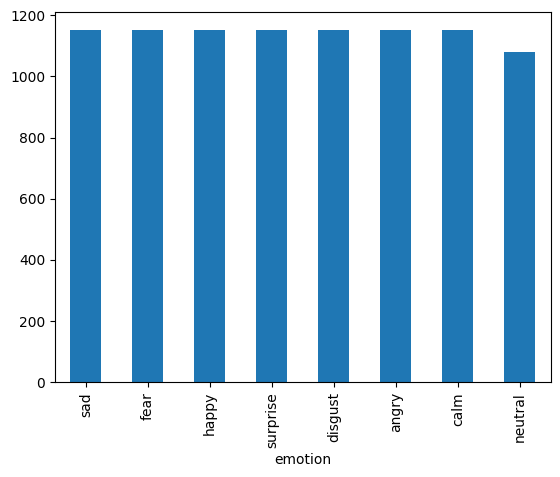

In [ ]:
df_oversampled['emotion'].value_counts().plot(kind='bar')

In [ ]:
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

In [ ]:
train,test = train_test_split(df_oversampled, test_size=0.2, random_state=0,
                               stratify=df_oversampled[['emotion','gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
6597,-64.393234,-64.377502,-64.382217,-64.387573,-64.386581,-64.383362,-64.395996,-64.449333,-64.449333,-64.449333,...,-64.336800,-64.180725,-64.207031,-64.263260,-64.339668,-64.345947,-64.263451,-64.220512,-64.226204,-64.340797
3334,-68.427246,-69.903358,-70.935730,-71.220116,-70.338631,-70.354431,-71.217537,-71.286568,-71.323792,-71.357162,...,-70.974731,-71.153091,-71.245667,-71.202599,-70.919121,-70.859489,-71.103386,-71.453423,-71.625771,-71.716049
4291,-74.039406,-71.730782,-71.959946,-72.985321,-74.380112,-75.758240,-77.203049,-76.922066,-76.842987,-76.978012,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6183,-53.551266,-53.693127,-53.673744,-53.500877,-53.377907,-53.341370,-53.349266,-53.424026,-53.506039,-53.358974,...,-47.374878,-48.553905,-49.681263,-50.305027,-50.940487,-51.199215,-51.628559,-51.920536,-52.447224,-52.784973
6918,-31.340193,-28.814119,-28.577604,-28.290775,-28.395819,-28.948364,-29.321220,-29.509497,-28.523054,-28.182230,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,-68.690681,-68.622223,-68.606071,-68.611320,-68.593437,-68.537567,-68.551506,-68.382004,-67.713684,-67.212311,...,-68.589676,-68.621117,-68.612373,-68.663162,-68.681923,-68.690811,-68.652786,-68.610550,-68.519089,-68.624649
2545,-64.558617,-64.301552,-63.846283,-63.855690,-63.341984,-62.977524,-62.810207,-61.950928,-61.175449,-60.267681,...,-63.464123,-63.844299,-64.133904,-64.165520,-64.227768,-64.161797,-64.021492,-63.908463,-63.834328,-63.721130
8593,-67.460007,-67.284958,-67.463455,-67.377426,-67.270050,-67.455315,-67.419502,-67.442009,-67.042030,-66.566483,...,-67.594810,-67.714317,-67.762810,-67.713486,-67.744431,-67.804359,-67.770584,-67.786926,-67.817764,-67.863121
4004,-75.437737,-75.352875,-75.433601,-75.395256,-75.363083,-75.259079,-75.283775,-75.332466,-75.239716,-75.107300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train.shape

(7315, 259)

In [ ]:
X_train

array([[-64.39323425, -64.37750244, -64.38221741, ..., -64.22051239,
        -64.22620392, -64.34079742],
       [-68.42724609, -69.90335846, -70.93572998, ..., -71.45342255,
        -71.62577057, -71.71604919],
       [-74.03940582, -71.73078156, -71.95994568, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-67.46000671, -67.28495789, -67.4634552 , ..., -67.78692627,
        -67.81776428, -67.86312103],
       [-75.43773651, -75.35287476, -75.43360138, ...,   0.        ,
          0.        ,   0.        ],
       [-31.45214081, -28.40550804, -28.20506477, ..., -28.98075104,
        -28.63706207, -29.5234127 ]])

In [ ]:
# Augment your training data
X_train_augmented = []
y_train_augmented = []

In [ ]:
for i in range(X_train.shape[0]):
    # Add original features
    X_train_augmented.append(X_train[i])
    y_train_augmented.append(y_train[i])

    # Create and add augmented version
    aug_spec = augment_features(X_train[i])
    X_train_augmented.append(aug_spec)
    y_train_augmented.append(y_train[i])

In [ ]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
# Shuffle the augmented dataset
indices = np.arange(len(X_train_augmented))
np.random.shuffle(indices)
X_train_augmented = X_train_augmented[indices]
y_train_augmented = y_train_augmented[indices]

In [ ]:
X_train_augmented

array([[-7.23780969e+01, -7.22202155e+01, -7.20910290e+01, ...,
        -7.20373023e+01, -7.23487861e+01,  1.70822661e-03],
       [-8.43853048e+01, -8.35476366e+01, -8.42549851e+01, ...,
        -8.35264066e+01, -8.36049551e+01, -8.55013952e+01],
       [-5.47508698e+01, -5.47508698e+01, -5.47508698e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.17381897e+01, -2.83145866e+01, -2.81774273e+01, ...,
        -2.88071899e+01, -2.77937450e+01, -2.96297207e+01],
       [-6.94814377e+01, -6.89693909e+01, -6.91588516e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.32443390e+01, -7.30368500e+01, -7.30182343e+01, ...,
        -7.23390656e+01, -7.22576752e+01, -7.18237762e+01]])

In [ ]:
X_train_augmented.shape

(14630, 259)

In [ ]:
# y_resampled.emotion.value_counts().plot(kind='bar')

In [ ]:
# Function to calculate skewness
def calculate_skewness(X):
    return np.abs(stats.skew(X, axis=0))

# Calculate skewness for each feature
skewness = calculate_skewness(X_train_augmented)

# Identify columns with significant skewness
skewed_columns = np.where(skewness > 0.5)[0]
skewed_columns

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        45,  46,  47, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250])

In [ ]:
# Initialize the PowerTransformer
pt = PowerTransformer(method="yeo-johnson", standardize=True)

# Transform the data
X_train_transformed = pt.fit_transform(X_train_augmented)
X_test_transformed = pt.transform(X_test)

In [ ]:
# Recalculate skewness after transformation
skewness_after = calculate_skewness(X_train_transformed)
# Identify columns with significant skewness
skewed_columns_after = np.where(skewness_after > 0.5)[0]
skewed_columns_after

array([ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258])

In [ ]:
X_train_transformed.shape

(14630, 259)

In [ ]:
mean = np.mean(X_train_transformed, axis=0)
std = np.std(X_train_transformed, axis=0)
X_train = (X_train_transformed - mean)/std
X_test = (X_test_transformed - mean)/std

In [ ]:
X_train = np.array(X_train_transformed)
y_train = np.array(y_train)
X_test = np.array(X_test_transformed)
y_test = np.array(y_test)

In [ ]:
X_train_transformed

array([[-0.5753843 , -0.60727326, -0.59533365, ..., -0.9097175 ,
        -0.91393952,  1.40963238],
       [-1.68768686, -1.62522903, -1.67205092, ..., -1.10194458,
        -1.10341166, -1.12978224],
       [ 0.67209208,  0.60813712,  0.59629446, ...,  1.42574897,
         1.42985201,  1.4093359 ],
       ...,
       [ 1.66900113,  1.69560406,  1.69393012, ...,  0.01882643,
         0.0537454 , -0.02625397],
       [-0.33958   , -0.34914159, -0.36594998, ...,  1.42574897,
         1.42985201,  1.4093359 ],
       [-0.64832057, -0.67447148, -0.67027944, ..., -0.91496262,
        -0.91234592, -0.90876614]])

In [ ]:
y_test

array([['happy'],
       ['surprise'],
       ['surprise'],
       ...,
       ['surprise'],
       ['neutral'],
       ['calm']], dtype=object)

In [ ]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train_augmented))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


Base Model

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.47840349917987973

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.04373974849644614

In [ ]:
y_train_augmented.shape

(14630, 1)

In [ ]:
X_train_transformed.shape

(14630, 259)

1D CNN Model

In [ ]:
# X_train_augmented, y_train_augmented = augment_dataset(X_train_transformed, y_train, sr=48000)

In [ ]:
# Convert DataFrames to NumPy arrays
X_train = np.array(X_train_transformed)
X_test = np.array(X_test_transformed)


In [ ]:
# Add new axis
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_train.shape

(14630, 259, 1)

In [ ]:
X_train.shape

(14630, 259, 1)

In [ ]:
y_train.shape

(14630, 8)

In [ ]:
y_test.shape

(1829, 8)

In [ ]:
X_test.shape

(1829, 259, 1)

In [ ]:
y_train_augmented.shape

(14630, 1)

In [ ]:
model = Sequential([
    # Input layer
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Second convolutional layer
    Conv1D(128, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Third convolutional layer
    Conv1D(256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Fourth convolutional layer (new)
    Conv1D(512, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Flatten layer to transition from CNN to Dense layers
    Flatten(),

    # Dense layers
    Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    # Dense layers (Linear Classifier)
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(8, activation='softmax')  # Assuming 7 emotion categories
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 259, 64)           384       
                                                                 
 batch_normalization (Batch  (None, 259, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 129, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 129, 128)          41088     
                                                                 
 batch_normalization_1 (Bat  (None, 129, 128)          512       
 chNormalization)                                                
                                                        

In [ ]:
opt = keras.optimizers.AdamW(learning_rate=0.0001)
model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.weights.h5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint], verbose=1)

Epoch 1/40
458/458 [==============================] - ETA: 0s - loss: 35.6402 - accuracy: 0.2185
Epoch 1: val_accuracy improved from -inf to 0.23619, saving model to best_initial_model.weights.h5
458/458 [==============================] - 20s 18ms/step - loss: 35.6402 - accuracy: 0.2185 - val_loss: 33.1729 - val_accuracy: 0.2362
Epoch 2/40
455/458 [============================>.] - ETA: 0s - loss: 31.9817 - accuracy: 0.2636
Epoch 2: val_accuracy improved from 0.23619 to 0.35648, saving model to best_initial_model.weights.h5
458/458 [==============================] - 8s 18ms/step - loss: 31.9719 - accuracy: 0.2638 - val_loss: 29.4107 - val_accuracy: 0.3565
Epoch 3/40
456/458 [============================>.] - ETA: 0s - loss: 28.2172 - accuracy: 0.2840
Epoch 3: val_accuracy improved from 0.35648 to 0.39858, saving model to best_initial_model.weights.h5
458/458 [==============================] - 7s 16ms/step - loss: 28.2117 - accuracy: 0.2840 - val_loss: 25.7698 - val_accuracy: 0.3986
Epo

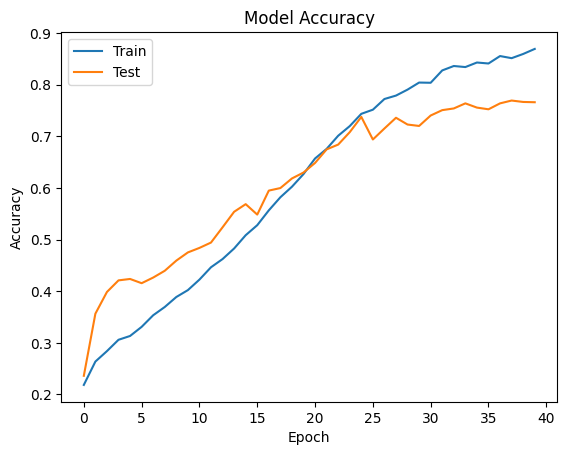

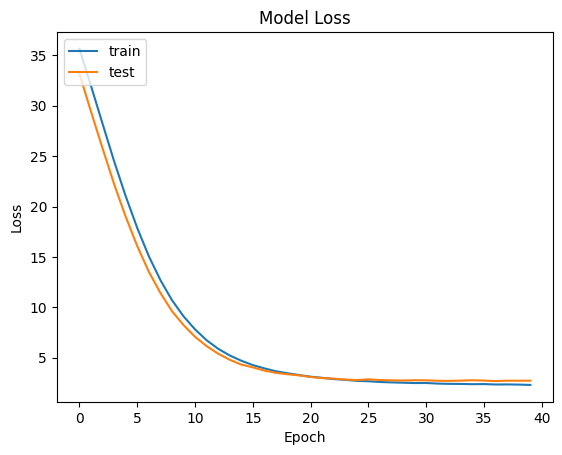

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
finaldf = actual.join(predictions)
finaldf[140:150]

58/58 [==============================] - 0s 3ms/step


,Actual Values,Predicted Values
140,fear,fear
141,sad,sad
142,angry,angry
143,fear,fear
144,happy,fear
145,sad,calm
146,fear,fear
147,disgust,disgust
148,neutral,neutral
149,surprise,surprise


<Axes: xlabel='Predicted Values'>

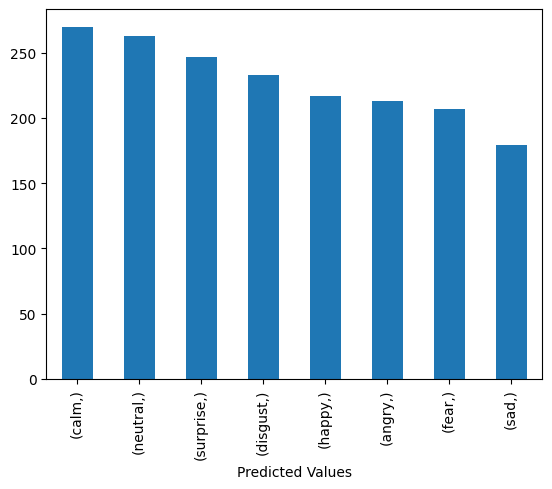

In [ ]:
predictions.value_counts().plot(kind='bar')

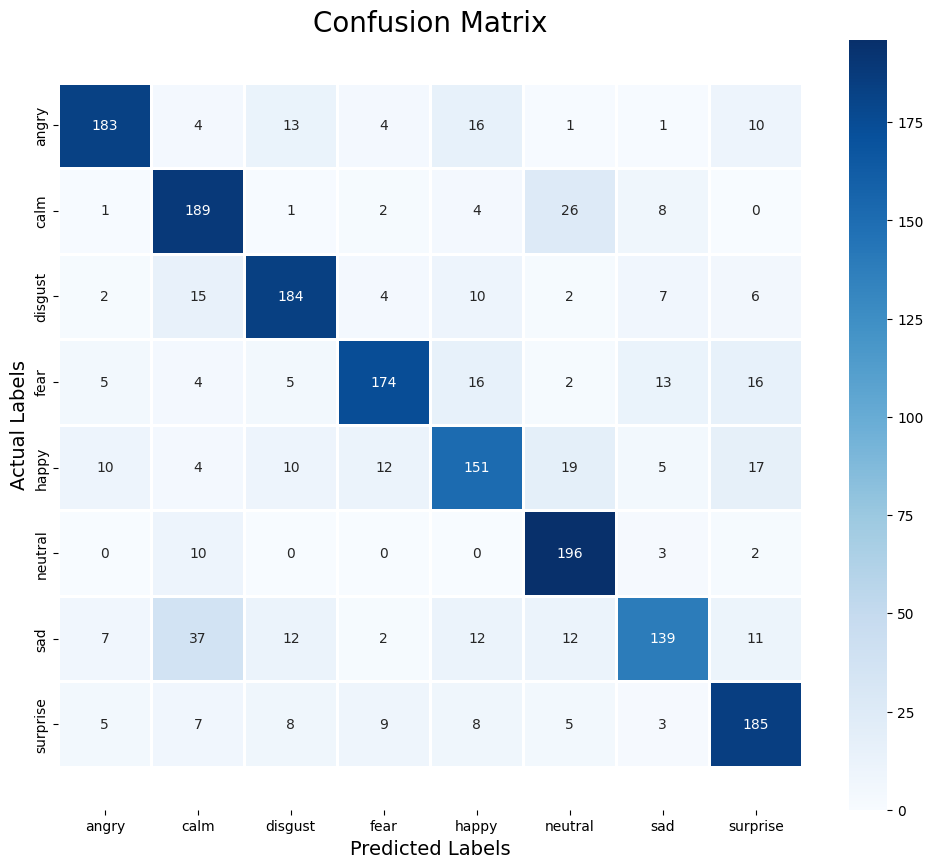

In [ ]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.86      0.79      0.82       232
        calm       0.70      0.82      0.75       231
     disgust       0.79      0.80      0.79       230
        fear       0.84      0.74      0.79       235
       happy       0.70      0.66      0.68       228
     neutral       0.75      0.93      0.83       211
         sad       0.78      0.60      0.68       232
    surprise       0.75      0.80      0.78       230

    accuracy                           0.77      1829
   macro avg       0.77      0.77      0.76      1829
weighted avg       0.77      0.77      0.76      1829



Trying SVM

In [ ]:
# Reshape X_train and X_test to 2D arrays before fitting the model
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# # Convert y_train and y_test back to 1D if they're one-hot encoded
if len(y_train.shape) > 1:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

In [ ]:
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [ ]:
# Make predictions
y_pred = svm_model.predict(X_test_scaled)

In [ ]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4980863860032805

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.53      0.58       232
           1       0.49      0.65      0.56       231
           2       0.55      0.62      0.58       230
           3       0.59      0.36      0.44       235
           4       0.35      0.34      0.34       228
           5       0.43      0.73      0.54       211
           6       0.53      0.29      0.38       232
           7       0.49      0.49      0.49       230

    accuracy                           0.50      1829
   macro avg       0.51      0.50      0.49      1829
weighted avg       0.51      0.50      0.49      1829



Performing RandomForest


In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42, )
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [ ]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [ ]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6905412793876435

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74       232
           1       0.69      0.83      0.76       231
           2       0.68      0.78      0.73       230
           3       0.76      0.58      0.66       235
           4       0.59      0.51      0.55       228
           5       0.75      0.89      0.81       211
           6       0.72      0.57      0.64       232
           7       0.58      0.67      0.62       230

    accuracy                           0.69      1829
   macro avg       0.69      0.69      0.69      1829
weighted avg       0.69      0.69      0.69      1829



In [ ]:
# Feature importance
feature_importance = rf_model.feature_importances_
print("\nTop 10 important features:")
top_features = np.argsort(feature_importance)[-10:]
for i in top_features:
    print(f"Feature {i}: {feature_importance[i]}")


Top 10 important features:
Feature 55: 0.005031227991566642
Feature 57: 0.005050188008431001
Feature 56: 0.005059694719055576
Feature 2: 0.005070186912624314
Feature 66: 0.005130050828296177
Feature 29: 0.005158775084453565
Feature 67: 0.005198222220987611
Feature 28: 0.005226673383940758
Feature 54: 0.005244309904507364
Feature 53: 0.00545695262702644


Combining RandomForest & SVM

In [ ]:
# Create the base models
rf_model = RandomForestClassifier(n_estimators=494, random_state=42)
svm_model_vc = SVC(kernel='rbf', probability=True, random_state=42)

In [ ]:
# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('svm', svm_model_vc)],
    voting='soft'
)

In [ ]:
# Fit the voting classifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=494,
                                                     random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
# Make predictions
y_pred = voting_clf.predict(X_test)

In [ ]:
# Evaluate the model
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Voting Classifier Accuracy: 0.608529250956807

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67       232
           1       0.61      0.72      0.66       231
           2       0.61      0.70      0.65       230
           3       0.69      0.51      0.59       235
           4       0.49      0.43      0.46       228
           5       0.59      0.91      0.71       211
           6       0.70      0.43      0.53       232
           7       0.53      0.57      0.55       230

    accuracy                           0.61      1829
   macro avg       0.62      0.61      0.60      1829
weighted avg       0.62      0.61      0.60      1829



In [ ]:
# Perform cross-validation to get a more robust estimate of performance
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

XGBoost on RandomForestFeatures

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
# # Feature selection using Random Forest
rf_selector = RandomForestClassifier(n_estimators=464, random_state=42)
selector = SelectFromModel(rf_selector, prefit=False)
selector.fit(X_train, y_train)

In [ ]:
# # Transform the data
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print(f"Number of features selected: {X_train_selected.shape[1]}")

In [ ]:
# # Train XGBoost on selected features
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_selected, y_train)

In [ ]:
# Make predictions
y_pred = xgb_model.predict(X_test_selected)

In [ ]:
# # Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Cross-validation
# cv_scores = cross_val_score(xgb_model, X_train_selected, y_train, cv=5)
# print("\nCross-validation scores:", cv_scores)
# print("Mean CV score:", cv_scores.mean())

Transfer Learning with VGG16
